In [1]:
import os
import difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches as mpatches

import sys
sys.path.append('../../')
from rllte.evaluation.visualization import _annotate_and_decorate_axis, plot_interval_estimates
from rllte.evaluation import Performance

In [2]:
root = '/Users/yuanmingqi/Downloads/nips2024_data/q8/'
for folder in os.listdir(root):
    if folder == '.DS_Store':
        continue
    if len(os.listdir(os.path.join(root, folder))) != 1:
        print(folder, os.listdir(os.path.join(root, folder)))

In [3]:
algos = ['E3B+RND', 'E3B+ICM', 'E3B+RIDE', 'RE3+RND', 'RE3+ICM', 'RE3+RIDE', 'ICM+RND', 'RIDE+RND', 'ICM+RIDE']
envs = ['SuperMarioBros-1-1-v3', 'SuperMarioBrosRandomStages']

for env in envs:
    root = f'/Users/yuanmingqi/Downloads/nips2024_data/q8/{env}'
    num_points = 10
    all_data = {algo: [] for algo in algos}
    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir:
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)#['episode_reward']
                if data['step'].values[-1] != 9999360:
                    print(env, dir)

# global + episodic (1)

SuperMarioBros-1-1-v3 E3B+RND (5, 1, 10)
SuperMarioBros-1-1-v3 E3B+ICM (5, 1, 10)
SuperMarioBros-1-1-v3 E3B+RIDE (5, 1, 10)
SuperMarioBros-1-1-v3 RE3+RND (5, 1, 10)
SuperMarioBros-1-1-v3 RE3+ICM (5, 1, 10)
SuperMarioBros-1-1-v3 RE3+RIDE (5, 1, 10)
SuperMarioBrosRandomStages E3B+RND (5, 1, 10)
SuperMarioBrosRandomStages E3B+ICM (5, 1, 10)
SuperMarioBrosRandomStages E3B+RIDE (5, 1, 10)
SuperMarioBrosRandomStages RE3+RND (5, 1, 10)
SuperMarioBrosRandomStages RE3+ICM (5, 1, 10)
SuperMarioBrosRandomStages RE3+RIDE (5, 1, 10)


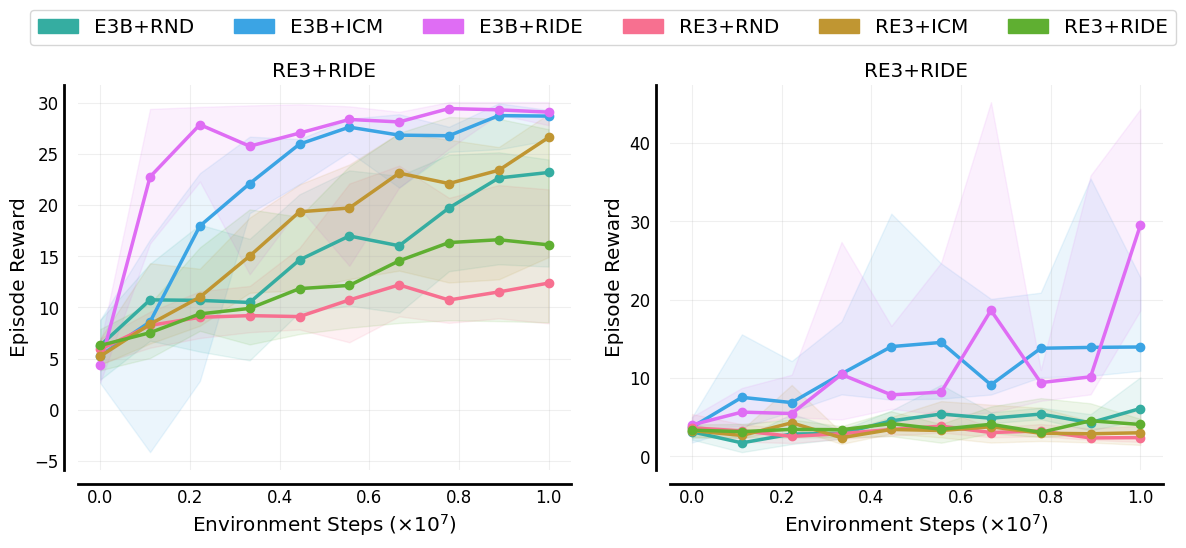

In [14]:
algos = ['E3B+RND', 'E3B+ICM', 'E3B+RIDE', 'RE3+RND', 'RE3+ICM', 'RE3+RIDE']
colors = sns.husl_palette(len(algos), h=.5)
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(algos)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for subplot_idx, candidate in enumerate(['SuperMarioBros-1-1-v3', 'SuperMarioBrosRandomStages']):
    root = f"/Users/yuanmingqi/Downloads/nips2024_data/q8/{candidate}/"
    num_points = 10
    all_data = {algo: [] for algo in algos}

    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir:
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)['episode_reward']
                data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
                all_data[algo].append(data)

        all_data[algo] = np.array(all_data[algo])
        all_data[algo] = np.expand_dims(all_data[algo], axis=1)
        print(candidate, algo, all_data[algo].shape)

    sampling_dict = dict()
    for algo in algos:
        sampling_dict[algo] = [[], [], []]
        for frame in range(num_points):
            perf = Performance(all_data[algo][:, :, frame], get_ci=True, reps=2000)
            value, CIs = perf.aggregate_iqm()
            sampling_dict[algo][0].append(value)
            sampling_dict[algo][1].append(CIs[0]) # lower bound
            sampling_dict[algo][2].append(CIs[1]) # upper bound

        sampling_dict[algo][0] = np.array(sampling_dict[algo][0]).reshape(-1)
        sampling_dict[algo][1] = np.array(sampling_dict[algo][1]).reshape(-1)
        sampling_dict[algo][2] = np.array(sampling_dict[algo][2]).reshape(-1)

    for algo_idx, algo in enumerate(algos):
        mean, ci_high, ci_low = sampling_dict[algo]
        ax = axes.flatten()[subplot_idx]
        x = np.linspace(0, 1, num_points)
        # if subplot_idx == 0:
            # ax.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
            # ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=colors[2], label='Extrinsic')
        ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=colors[algo_idx], label=algo)
        ax.fill_between(x, ci_high, ci_low, alpha=0.1, color=colors[algo_idx])
        ax.set_title(algos[algo_idx], fontsize="x-large")
        ax = _annotate_and_decorate_axis(ax, 
                                        ticklabelsize="large",
                                        xlabel=r"Environment Steps ($\times 10^7$)", 
                                        ylabel="Episode Reward",
                                        xticklabels=np.linspace(0, 1, num_points),
                                        )
        
fig.legend(fake_patches, algos, loc='upper center', 
    fancybox=True, ncol=len(algos), 
    fontsize='x-large',
    bbox_to_anchor=(0.5, 1.05))
fig.savefig('figure_rq8_curves_1.pdf', bbox_inches='tight', dpi=300)

# global+global

SuperMarioBros-1-1-v3 ICM+RND (5, 1, 10)
SuperMarioBros-1-1-v3 RIDE+RND (5, 1, 10)
SuperMarioBros-1-1-v3 ICM+RIDE (5, 1, 10)
SuperMarioBrosRandomStages ICM+RND (5, 1, 10)
SuperMarioBrosRandomStages RIDE+RND (5, 1, 10)
SuperMarioBrosRandomStages ICM+RIDE (5, 1, 10)


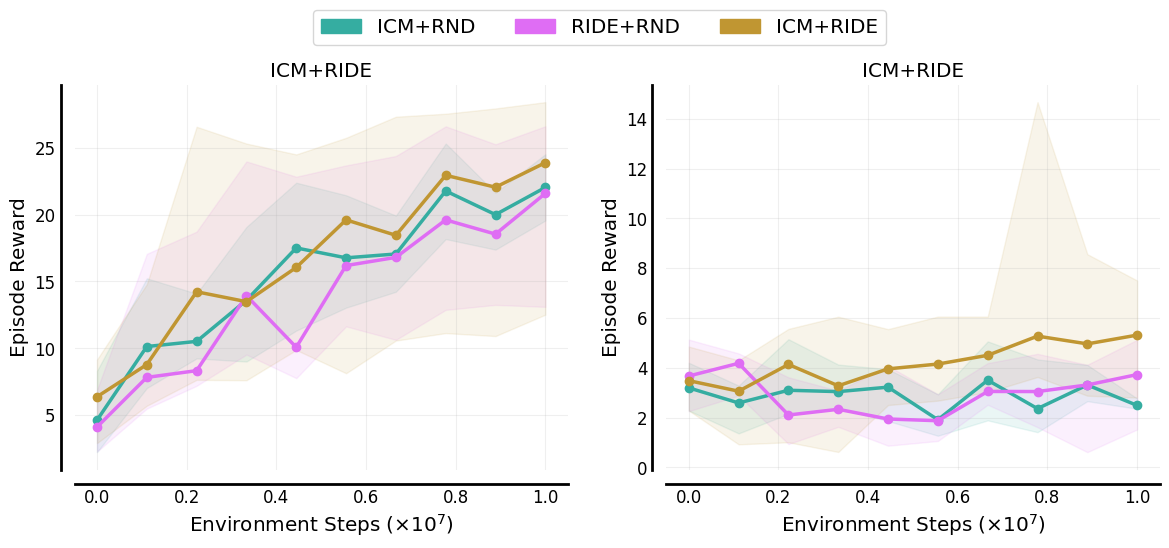

In [13]:
algos = ['ICM+RND', 'RIDE+RND', 'ICM+RIDE']
colors = sns.husl_palette(len(algos), h=.5)
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(algos)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for subplot_idx, candidate in enumerate(['SuperMarioBros-1-1-v3', 'SuperMarioBrosRandomStages']):
    root = f"/Users/yuanmingqi/Downloads/nips2024_data/q8/{candidate}/"
    num_points = 10
    all_data = {algo: [] for algo in algos}

    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir:
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)['episode_reward']
                data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
                all_data[algo].append(data)

        all_data[algo] = np.array(all_data[algo])
        all_data[algo] = np.expand_dims(all_data[algo], axis=1)
        print(candidate, algo, all_data[algo].shape)

    sampling_dict = dict()
    for algo in algos:
        sampling_dict[algo] = [[], [], []]
        for frame in range(num_points):
            perf = Performance(all_data[algo][:, :, frame], get_ci=True, reps=2000)
            value, CIs = perf.aggregate_iqm()
            sampling_dict[algo][0].append(value)
            sampling_dict[algo][1].append(CIs[0]) # lower bound
            sampling_dict[algo][2].append(CIs[1]) # upper bound

        sampling_dict[algo][0] = np.array(sampling_dict[algo][0]).reshape(-1)
        sampling_dict[algo][1] = np.array(sampling_dict[algo][1]).reshape(-1)
        sampling_dict[algo][2] = np.array(sampling_dict[algo][2]).reshape(-1)

    for algo_idx, algo in enumerate(algos):
        mean, ci_high, ci_low = sampling_dict[algo]
        ax = axes.flatten()[subplot_idx]
        x = np.linspace(0, 1, num_points)
        # if subplot_idx == 0:
            # ax.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
            # ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=colors[2], label='Extrinsic')
        ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=colors[algo_idx], label=algo)
        ax.fill_between(x, ci_high, ci_low, alpha=0.1, color=colors[algo_idx])
        ax.set_title(algos[algo_idx], fontsize="x-large")
        ax = _annotate_and_decorate_axis(ax, 
                                        ticklabelsize="large",
                                        xlabel=r"Environment Steps ($\times 10^7$)", 
                                        ylabel="Episode Reward",
                                        xticklabels=np.linspace(0, 1, num_points),
                                        )
        
fig.legend(fake_patches, algos, loc='upper center', 
    fancybox=True, ncol=len(algos), 
    fontsize='x-large',
    bbox_to_anchor=(0.5, 1.05))
fig.savefig('figure_rq8_curves_2.pdf', bbox_inches='tight', dpi=300)